## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [2]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

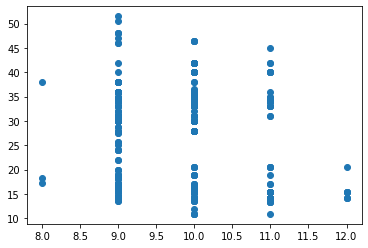

In [3]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

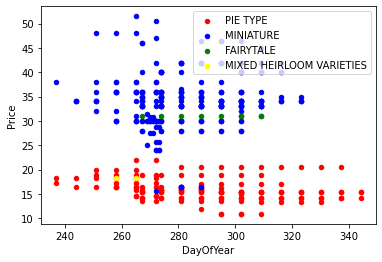

In [4]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

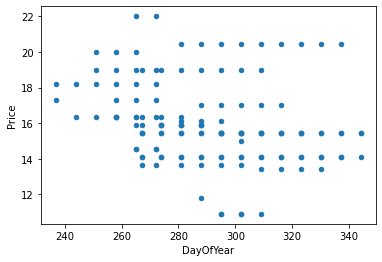

In [5]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price') 

In [6]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    int64  
 1   DayOfYear   144 non-null    int64  
 2   Variety     144 non-null    object 
 3   City        144 non-null    object 
 4   Package     144 non-null    object 
 5   Low Price   144 non-null    float64
 6   High Price  144 non-null    float64
 7   Price       144 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 10.1+ KB


/var/folders/7c/z8hzpqb12s78xtm6lcbxlwtm0000gn/T/ipykernel_43832/3144308612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie_pumpkins.dropna(inplace=True)


## Simple Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [8]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
X_train.shape

(115, 1)

In [11]:
X_test.shape

(29, 1)

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [13]:
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.77 (17.2%)


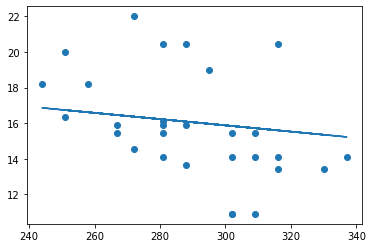

In [14]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [15]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

## Polynomial Regression

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [17]:
pred_2 = pipeline.predict(X_test)

In [18]:
pred_2.shape

(29,)

In [19]:
mse = np.sqrt(mean_squared_error(y_test,pred_2))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.73 (17.0%)


In [20]:
score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.07639977655280195


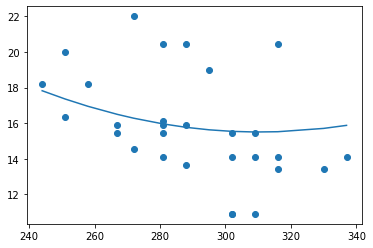

In [21]:
pred_2 = pipeline.predict(sorted(X_test))

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pred_2)

## Categorical Features

<AxesSubplot:xlabel='Variety'>

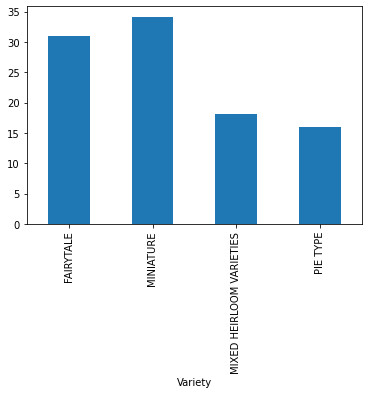

In [22]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

In [23]:
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,0,0,0,1
71,0,0,0,1
72,0,0,0,1
73,0,0,0,1
74,0,0,0,1
...,...,...,...,...
1738,0,1,0,0
1739,0,1,0,0
1740,0,1,0,0
1741,0,1,0,0


In [24]:
# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.22 (8.24%)
Model determination:  0.9652781917374332
